### Boundary strength vs CTCF binding properties

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pybedtools as pbt
import os
import csv
import fanc
import fanc.plotting as fancplot
import pickle
import re

%matplotlib inline 

In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be remove

#### 1. Load CTCF BS and get multifasta of CTCF peaks  

In [2]:
mm10_chromsizes = "../data/genomes/chrom-sizes/mm10.chrom.sizes"
mm10_fasta = "../data/genomes/mm10.fa"
ctcf_fname = "../data/bonev/CTCF_mESC/GSE96107_ES_CTCF.IDR0.05.filt.bed"
ctcf_fasta = os.path.splitext(ctcf_fname)[0] + ".fa"
blacklist = pbt.BedTool("1-FilterLowCoverage/HiC_mESC_Bonev_25kb_blacklist.bed").slop(b=125000,g=mm10_chromsizes)

#ctcf_mESC = pbt.BedTool(ctcf_fname)
#ctcf_mESC = ctcf_mESC.sequence(fi=mm10_fasta) 
#ctcf_mESC.save_seqs(ctcf_fasta)

#### 2. Run FIMO with CTCF BS sequences and CTCF PWM

In [3]:
fimo = "fimo" #path to fimo binary
ctcf_PWM = "../data/bonev/aux/CTCF_meme_PWM.txt"
fimoFolder = "../data/bonev/CTCF_mESC/fimo/"
#!{fimo} --bfile --motif-- --max-stored-scores 1000000 -o {fimoFolder} {ctcf_PWM} {ctcf_fasta}
fimoMotifs = pd.read_csv(fimoFolder + "/fimo.tsv",sep="\t",comment="#")

#### 3. Select highest scoring motif in each peak to assign strand // Create BED6

In [4]:
topMotifs = fimoMotifs.sort_values(["sequence_name","q-value"]).drop_duplicates(subset="sequence_name")
motifBed = pd.DataFrame(topMotifs["sequence_name"].str.split(":",expand=True))
motifBed.columns = ["chrom","coord"]
motifBed[["start","end"]] = motifBed["coord"].str.split("-",expand=True)
del motifBed["coord"]
motifBed[["name","score","strand"]] = topMotifs[["matched_sequence","score","strand"]]

In [5]:
motifBedEnsembl = motifBed.copy()
motifBedEnsembl["chrom"] = motifBedEnsembl["chrom"].str.extract("chr(.*)")
motifBedEnsembl.query("strand=='+'").to_csv("2-CTCF-insulation/Bonev_mESC_CTCF+.bed",sep="\t",index=False,header=False)
motifBedEnsembl.query("strand=='-'").to_csv("2-CTCF-insulation/Bonev_mESC_CTCF-.bed",sep="\t",index=False,header=False)

In [6]:
motifBedEnsembl.to_csv("2-CTCF-insulation/Bonev_mESC_CTCF.bed",sep="\t",index=False,header=False)

#### 4. Load HiC and calculate insulation and boundaries

In [7]:
HiC_mESC = fanc.load("../data/bonev/HiC//ES_mapq30/ES_mapq30.hic@25000@KR")

In [8]:
windowSize = 250000
insulationFilename = ("2-CTCF-insulation/Bonev_mESc_25kb_iw{}kb.insulation".
                      format(windowSize//1000))
insulation = fanc.InsulationScores.from_hic(HiC_mESC,
                                            window_sizes=windowSize,
                                            file_name=insulationFilename)
#insulation = fanc.load(insulationFilename)
insulationBedFilename = "2-CTCF-insulation/Bonev_mESc_25kb_iw250kb.insulation.bg"
insulation.to_bed(insulationBedFilename,parameter=windowSize)

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/fanc/architecture/domains.py:410: RuntimeWarning: divide by zero encountered in log2
  ins_matrix = np.log2(ins_matrix)


'2-CTCF-insulation/Bonev_mESc_25kb_iw250kb.insulation.bg'

In [12]:
fancBoundaries_mESC = fanc.Boundaries.from_insulation_score(insulation,
                                                            window_size=windowSize)
fancBoundariesFilename = "2-CTCF-insulation/Bonev_mESc_25kb_iw250kb_boundaries.bed"
fancBoundaries_mESC.to_bed(fancBoundariesFilename)

#### 5. Intersect FANC boundaries with CTCF motifs
+-100kb windows around the FANC boundaries are considered.

In [14]:
fancBoundaries_mESC_250kb = pd.read_csv(fancBoundariesFilename,sep="\t",header=None)
fancBoundaries_mESC_250kb[0]="chr"+fancBoundaries_mESC_250kb[0].map(str)
fancBoundaries_mESC_250kb.to_csv(fancBoundariesFilename,sep="\t",header=False,index=False)

In [15]:
colNames = ["chrom","boundaryStart","boundaryEnd","boundaryScore",
            "ctcfStart","ctcfEnd","ctcfScore","ctcfStrand"]

fancBoundaries_mESC_250kb = (pbt.BedTool(fancBoundariesFilename).
                             slop(b=100000,g=mm10_chromsizes).
                             intersect(pbt.BedTool().from_dataframe(motifBed),wa=True,wb=True).
                             to_dataframe(usecols=[0,1,2,4,7,8,10,11],names=colNames))

Saving those CTCF sites located in boundaries to a file

In [16]:
colNames = ["chrom","ctcfStart","ctcfEnd","ctcfScore","ctcfStrand"]
fancBoundaries_ctcfPeaks = (pbt.BedTool().from_dataframe(fancBoundaries_mESC_250kb[colNames]).
                            slop(b=2000,g=mm10_chromsizes).
                            to_dataframe(names=colNames))

In [18]:
plusCtcf = "2-CTCF-insulation/FANC_boundaries_plusCTCF.bed"
minusCtcf = "2-CTCF-insulation/FANC_boundaries_minusCTCF.bed"

fancBoundaries_ctcfPeaks.query("ctcfStrand=='+'")[["chrom","ctcfStart","ctcfEnd","ctcfScore"]].to_csv(plusCtcf,sep="\t",quoting=0,index=False,header=False)
fancBoundaries_ctcfPeaks.query("ctcfStrand=='-'")[["chrom","ctcfStart","ctcfEnd","ctcfScore"]].to_csv(minusCtcf,sep="\t",quoting=0,index=False,header=False)

ctcfPeaksPlot = fancplot.BarPlot([plusCtcf,minusCtcf],colors=["red","blue"],title="CTCF peaks")

Aggregate the intersection to keep only one row per boundary

In [19]:
fancBoundaries_mESC_250kb_agg = (fancBoundaries_mESC_250kb.
                                 reset_index().
                                 groupby(["chrom","boundaryStart","boundaryEnd","boundaryScore"]).
                                 agg(ctcfScore=("ctcfScore","median"),
                                     ctcfStrand=("ctcfStrand",lambda x:"both" if len(x.unique())==2 else "single"),
                                     ctcfNumber=("index",len)).
                                 reset_index())
    

In [20]:
fancBoundaries_mESC_ensembl = fancBoundaries_mESC_250kb_agg.copy()
fancBoundaries_mESC_ensembl["chrom"] = fancBoundaries_mESC_ensembl["chrom"].str.extract("chr(.*)")

In [22]:
fancBoundariesSingle = "2-CTCF-insulation/FANC_boundaries_singleStrand.bed"
(fancBoundaries_mESC_ensembl.query("ctcfStrand=='single'")[["chrom","boundaryStart","boundaryEnd","boundaryScore"]].
 to_csv(fancBoundariesSingle,sep="\t",index=False,header=False,quoting=0))
fancBoundariesBoth = "2-CTCF-insulation/FANC_boundaries_bothStrands.bed"
(fancBoundaries_mESC_ensembl.query("ctcfStrand=='both'")[["chrom","boundaryStart","boundaryEnd","boundaryScore"]].
 to_csv(fancBoundariesBoth,sep="\t",index=False,header=False,quoting=0))

In [23]:
fancBoundariesPlot= fancplot.BarPlot([fancBoundariesSingle,fancBoundariesBoth],
                                     title="FANC boundaries",
                                     colors=['#432371',"#FAAE7B"])

#### 6. Fanc boundary score plots

In [24]:
fancBoundaries_mESC_250kb_agg["ctcfNumberTop"]=(fancBoundaries_mESC_250kb_agg["ctcfNumber"].
                                                apply(lambda x:10 if x>=10 else x))

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 52.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(ms

<AxesSubplot:xlabel='ctcfNumberTop', ylabel='boundaryScore'>

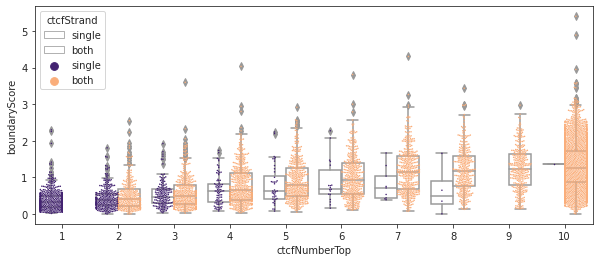

In [25]:
plt.figure(figsize=(10,4))
sns.boxplot(x="ctcfNumberTop",
              y="boundaryScore",
              hue="ctcfStrand",
              data=fancBoundaries_mESC_250kb_agg,
              palette=['white',"white"],
              hue_order=["single","both"])
              
sns.swarmplot(x="ctcfNumberTop",
              y="boundaryScore",
              hue="ctcfStrand",
              data=fancBoundaries_mESC_250kb_agg,
              dodge=True,size=1.5,
              palette=['#432371',"#FAAE7B"],
              hue_order=["single","both"])
              

### Divergent pairs

In [26]:
def findDivergent(strands):
    strandDict = {"+":"1","-":"0"}
    strands = "".join(strands.map(strandDict).values.tolist())
    divergent = -1
    matches = 1
    while matches == 1:
        divergent+=1
        strands, matches = re.subn("0(0*?)1","\\1",strands,count=1)
    return(divergent)

In [27]:
fancBoundaries_mESC_250kb_divergent = (fancBoundaries_mESC_250kb.
                                       reset_index().
                                       groupby(["chrom","boundaryStart","boundaryEnd","boundaryScore"]).
                                       agg(ctcfScore=("ctcfScore","median"),
                                           divergentPairs=("ctcfStrand",findDivergent),
                                           ctcfStrand=("ctcfStrand",lambda x:"both" if len(x.unique())==2 else "single"),
                                           ctcfNumber=("index",len)).
                                       reset_index())

In [28]:
cols = fancBoundaries_mESC_250kb_divergent.columns.tolist()

fancBoundaries_mESC_250kb_divergent = (pbt.BedTool().from_dataframe(fancBoundaries_mESC_250kb_divergent).
                   intersect(blacklist,wa=True,v=True).
                   to_dataframe(names=cols))

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='divergentPairs', ylabel='count'>

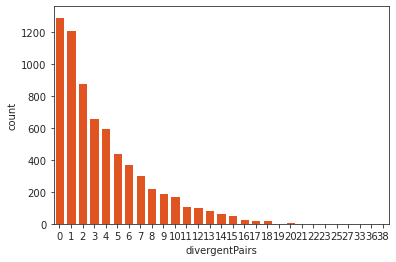

In [29]:
sns.countplot(fancBoundaries_mESC_250kb_divergent["divergentPairs"],color="orangered")

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


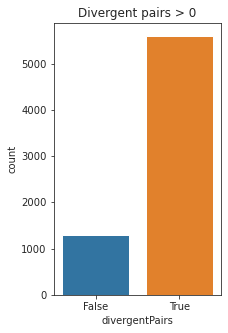

In [30]:
plt.figure(figsize=(3,5))
sns.countplot(fancBoundaries_mESC_250kb_divergent["divergentPairs"]>0)
plt.title("Divergent pairs > 0")
plt.savefig("figurePlots/DivergentCTCF_count.pdf")

In [34]:
sns.countplot(x="ctcfStrand",data=fancBoundaries_mESC_250kb_divergent,order=["single","both"])

<AxesSubplot:xlabel='ctcfStrand', ylabel='count'>

<AxesSubplot:xlabel='divergentPairs', ylabel='count'>

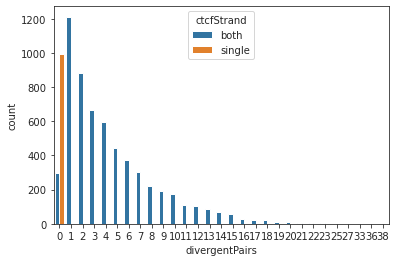

In [35]:
sns.countplot(x="divergentPairs",hue="ctcfStrand",data=fancBoundaries_mESC_250kb_divergent)

In [36]:
fancBoundaries_mESC_250kb_divergent["divergent"]=fancBoundaries_mESC_250kb_divergent["divergentPairs"] > 0
fancBoundaries_mESC_250kb_divergent["divergentTop"]=fancBoundaries_mESC_250kb_divergent["divergentPairs"].apply(lambda x:10 if x>9 else x)
fancBoundaries_mESC_250kb_divergent["ctcfTop"]=fancBoundaries_mESC_250kb_divergent["ctcfNumber"].apply(lambda x:15 if x>14 else x)

In [37]:
sns.boxplot(x="divergent",y="boundaryScore",data=fancBoundaries_mESC_250kb_divergent,notch=True)

<AxesSubplot:xlabel='divergent', ylabel='boundaryScore'>

In [38]:
fancBoundaries_mESC_250kb_divergent["ctcfTop"]=fancBoundaries_mESC_250kb_divergent["ctcfNumber"].apply(lambda x:15 if x>14 else x)
sns.boxplot(x="ctcfTop",y="boundaryScore",data=fancBoundaries_mESC_250kb_divergent,color="orange")
plt.savefig("figurePlots//BS_vs_nCtcf.pdf")

<AxesSubplot:xlabel='divergentTop', ylabel='boundaryScore'>

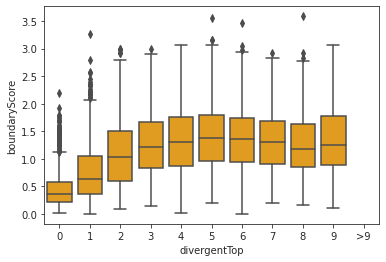

In [39]:
sns.boxplot(x="divergentTop",y="boundaryScore",data=fancBoundaries_mESC_250kb_divergent,color="orange",order=[x for x in range(10)]+[">9"])

In [34]:
fancBoundaries_mESC_250kb_divergent["ctcfTop"]=fancBoundaries_mESC_250kb_divergent["ctcfNumber"].apply(lambda x:8 if x>7 else x)
plt.figure(figsize=(10,4))
sns.boxplot(x="ctcfTop",
              y="boundaryScore",
              hue="divergent",
              data=fancBoundaries_mESC_250kb_divergent,
              palette=['white',"white"],
            order=range(1,9),
            hue_order=[False,True],
            dodge=True)
sns.swarmplot(x="ctcfTop",
              y="boundaryScore",
              hue="divergent",
              size=1.5,
              data=fancBoundaries_mESC_250kb_divergent,
              palette=['#432371',"#FAAE7B"],
              order=range(1,9),
            hue_order=[False,True],
            dodge=True)
plt.savefig("figurePlots//BS_vs_nCtcf_vs_divergent.pdf",dpi=300)

/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 24.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 11.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast/AG_Lupianez/rdoming/anaconda3/envs/hic/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 60.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


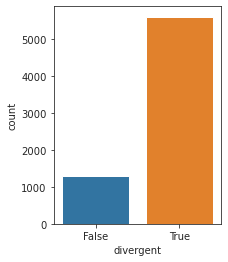

In [40]:
plt.figure(figsize=(3,4))
sns.countplot(x="divergent",data=fancBoundaries_mESC_250kb_divergent)
plt.savefig("figurePlots/divergentProportion.pdf",bbox_inches="tight")

In [42]:
fancBoundaries_mESC_250kb_divergent[">1"] = fancBoundaries_mESC_250kb_divergent["boundaryScore"]>1